## Handling Multimodal Distributions & FE Techniques

- https://www.kaggle.com/code/iamleonie/handling-multimodal-distributions-fe-techniques

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

bimodal distribution of the target variable and multimodal distributions of the feature 문제 접근

In [2]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [3]:
train = pd.read_csv("../data/tabular-playground-series/train.csv")
test = pd.read_csv("../data/tabular-playground-series/test.csv")

print(train.shape)
train.head()

(300000, 16)


,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046


In [4]:
print(f"Missing data in the train data: {train.isna().sum(axis=0).any()}")
print(f"Missing data in the test data: {test.isna().sum(axis=0).any()}")

Missing data in the train data: False
Missing data in the test data: False


### Modality

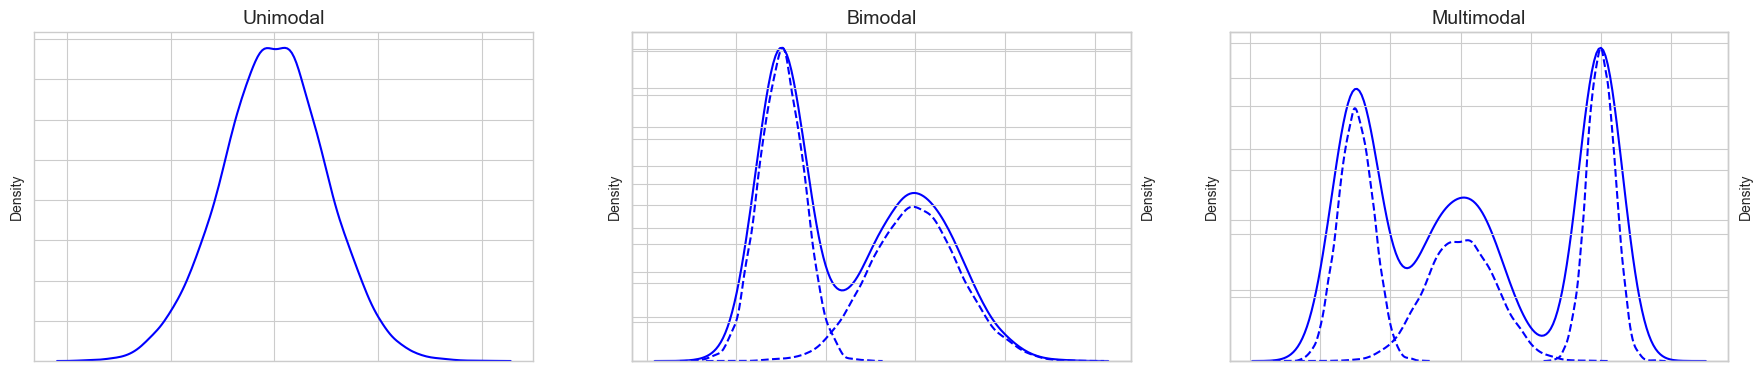

In [5]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

# Unimodal
sns.distplot(np.random.normal(10, 5, 10000), ax=ax[0], hist=False, color='blue')
ax[0].set_title('Unimodal', fontsize=14)
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])

# Bimodal
sample_bimodal = pd.DataFrame({'feature1' : np.random.normal(10, 5, 10000),
                   'feature2' : np.random.normal(40, 10, 10000),
                   'feature3' : np.random.randint(0, 2, 10000),
                  })

sample_bimodal['combined'] = sample_bimodal.apply(lambda x: x.feature1 if (x.feature3 == 0 ) else x.feature2, axis=1)

sns.distplot(sample_bimodal['combined'].values, ax=ax[1], color='blue', hist=False)

ax2 = ax[1].twinx()  # instantiate a second axes that shares the same x-axis

sns.distplot(sample_bimodal.feature1, ax=ax2, color='blue', kde_kws={'linestyle':'--'}, hist=False)
sns.distplot((sample_bimodal.feature2), ax=ax2, color='blue', kde_kws={'linestyle':'--'}, hist=False)

f.tight_layout()  # otherwise the right y-label is slightly clipped

ax[1].set_title('Bimodal', fontsize=14)
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax2.set_yticklabels([])

# Multimodal
sample_multi = pd.DataFrame({'feature1' : np.random.normal(10, 5, 10000),
                   'feature2' : np.random.normal(40, 10, 10000),
                   'feature3' : np.random.randint(0, 3, 10000),
                               'feature4' : np.random.normal(80, 4, 10000),
                  })

sample_multi['combined'] = sample_multi.apply(lambda x: x.feature1 if (x.feature3 == 0 ) else (x.feature2 if x.feature3 == 1 else x.feature4), axis=1 )

sns.distplot(sample_multi['combined'].values, ax=ax[2], color='blue', hist=False)

ax3 = ax[2].twinx()  # instantiate a second axes that shares the same x-axis

sns.distplot(sample_multi.feature1, ax=ax3, color='blue', kde_kws={'linestyle':'--'}, hist=False)
sns.distplot((sample_multi.feature2), ax=ax3, color='blue', kde_kws={'linestyle':'--'}, hist=False)
sns.distplot((sample_multi.feature4), ax=ax3, color='blue', kde_kws={'linestyle':'--'}, hist=False)

f.tight_layout()  # otherwise the right y-label is slightly clipped

ax[2].set_title('Multimodal', fontsize=14)
ax[2].set_yticklabels([])
ax[2].set_xticklabels([])
ax3.set_yticklabels([])

plt.show()

### Data Overview

타겟 
- 두개의 피크가 존재 : 두개의 다른 분포가 합쳐진 형태  
- 0 근처에 아웃라이어 존재 : 제거 필요
- skew가 심하지는 않다. transform 불필요

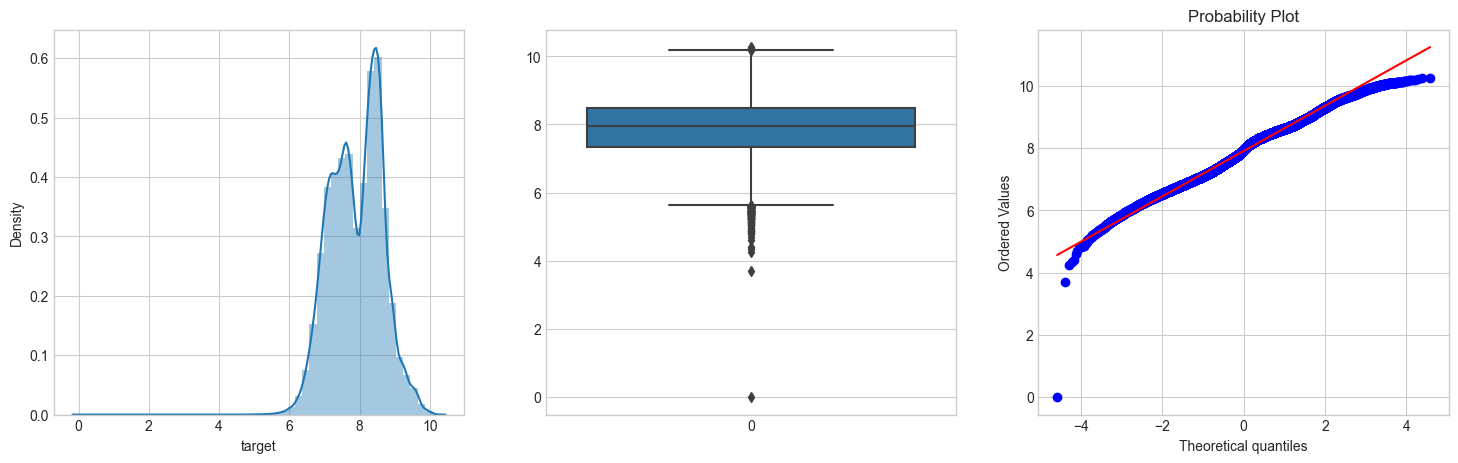

In [6]:
#display(train_df.target.describe())
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
sns.distplot(train.target, ax=ax[0])
sns.boxplot(train.target, ax=ax[1])
stats.probplot(train['target'], plot=ax[2])
plt.show()

In [7]:
# drop outlier
train = train[train.target != 0].reset_index(drop = True)

,feature1,feature2,feature3,target
0,10.052696,38.904467,0,10.052696
1,8.578921,40.364789,1,40.364789
2,12.871479,46.050084,0,12.871479
3,19.307500,28.304064,1,28.304064
4,12.016627,29.635146,0,12.016627


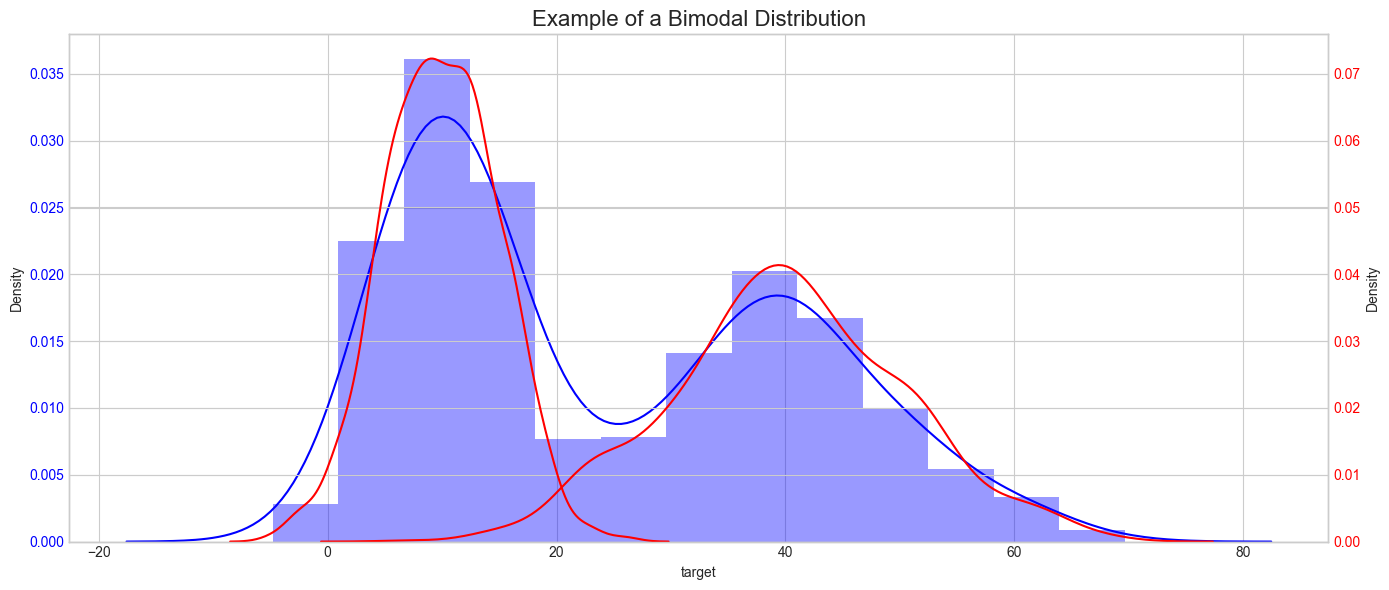

In [8]:
df = pd.DataFrame({'feature1' : np.random.normal(10, 5, 1000),
                   'feature2' : np.random.normal(40, 10, 1000),
                   'feature3' : np.random.randint(0, 2, 1000),
                  })

df['target'] = df.apply(lambda x: x.feature1 if (x.feature3 == 0 ) else x.feature2, axis=1)

display(df.head())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
color = 'blue'
sns.distplot(df.target, ax=ax, color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
sns.distplot(df.feature1, ax=ax2, color=color, hist=False)
sns.distplot((df.feature2), ax=ax2, color=color, hist=False)

ax2.tick_params(axis='y', labelcolor=color)
ax.set_title('Example of a Bimodal Distribution', fontsize=16)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Continuous features  
- 각 피처들은 피크가 여러개인 분포를 형성한다.   

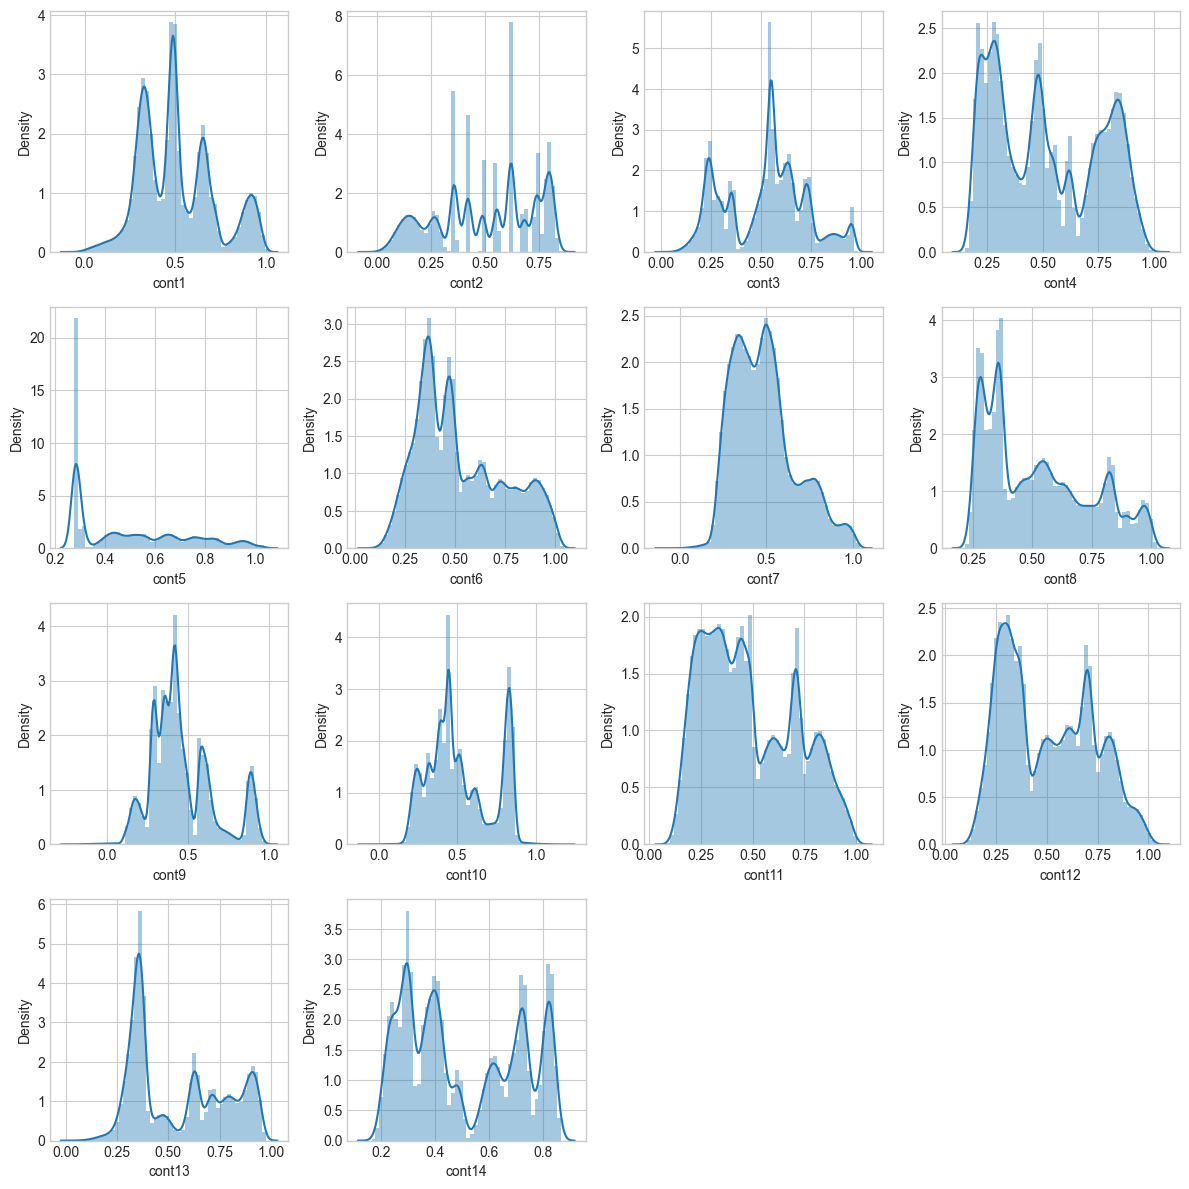

In [9]:
f, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
#f.suptitle('Distribution of Features', fontsize=16)
sns.distplot(train['cont1'], ax=ax[0, 0])
sns.distplot(train['cont2'], ax=ax[0, 1])
sns.distplot(train['cont3'], ax=ax[0, 2])
sns.distplot(train['cont4'], ax=ax[0, 3])

sns.distplot(train['cont5'], ax=ax[1, 0])
sns.distplot(train['cont6'], ax=ax[1, 1])
sns.distplot(train['cont7'], ax=ax[1, 2])
sns.distplot(train['cont8'], ax=ax[1, 3])

sns.distplot(train['cont9'], ax=ax[2, 0])
sns.distplot(train['cont10'], ax=ax[2, 1])
sns.distplot(train['cont11'], ax=ax[2, 2])
sns.distplot(train['cont12'], ax=ax[2, 3])

sns.distplot(train['cont13'], ax=ax[3, 0])
sns.distplot(train['cont14'], ax=ax[3, 1])
f.delaxes(ax[3, 2])
f.delaxes(ax[3, 3])
plt.tight_layout()
plt.show()

상관도 매트릭스

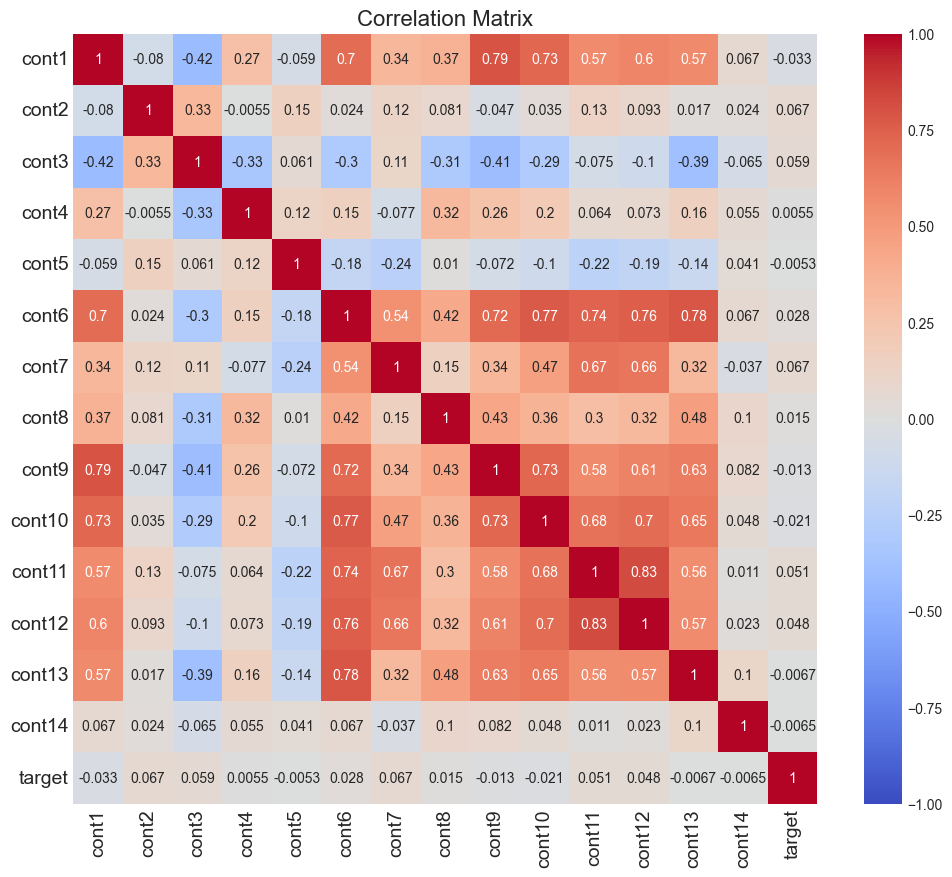

In [10]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_title("Correlation Matrix", fontsize=16)
sns.heatmap(train[train.columns[train.columns != 'id']].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    tick.label.set_rotation(90) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    tick.label.set_rotation(0) 
plt.show()

### Model baseline

In [11]:

# Baseline model parameters copied from
# https://www.kaggle.com/ttahara/tps-jan-2021-gbdts-baseline

model_params = {
    "objective": "root_mean_squared_error",
    "learning_rate": 0.1, 
    "seed": 42,
    'max_depth': 7,
    'colsample_bytree': .85,
    "subsample": .85,
}
    
train_params = {
    "early_stopping_rounds": 100,
    "verbose_eval": 50,
}

def visualize_results(y_pred, y_train, features, feature_importances):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    color = 'blue'
    ax[0].set_ylabel('Ground Truth', color=color, fontsize=14)
    sns.distplot(y_train, ax=ax[0], color=color)
    ax[0].tick_params(axis='y', labelcolor=color)

    ax2 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'red'
    ax2.set_ylabel('Predicted', color=color, fontsize=14)  # we already handled the x-label with ax1
    sns.distplot(pd.Series(y_pred), ax=ax2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax[0].set_title('Distribution of Predicted Values and Ground Truth', fontsize=16)

    pd.DataFrame({'features' : features, 
                  'feature_importance': feature_importances}
                ).set_index('features').sort_values(by='feature_importance', ascending=False).head(10).plot(kind='bar', ax=ax[1])
    ax[1].set_title('Top 10 Most Important Features', fontsize=16)

    for tick in ax[1].yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
        tick.label.set_rotation(0) 

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [12]:
# Configurations
N_SPLITS = 5
SEED = 42

In [13]:
def run_model(X, y, X_test):
    # 변수 초기화
    y_oof_pred = np.zeros(len(X))
    y_test_pred = np.zeros(len(X_test))
    
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"Fold {fold + 1}:")
        
        # Prepare training and validation data
        X_train = X.iloc[train_idx].reset_index(drop=True)
        X_val = X.iloc[val_idx].reset_index(drop=True)

        y_train = y.iloc[train_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)  

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        
        # Define model
        model = lgb.train(params=model_params,
                          train_set=train_data,
                          valid_sets=[train_data, val_data],
                          **train_params)

        # Calculate evaluation metric: Root Mean Squared Error (RMSE)
        y_val_pred = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_val_pred))
        print(f"RMSE: {score:.5f}\n")

        y_oof_pred[val_idx] = y_val_pred

        # Make predictions
        y_test_pred += model.predict(X_test)
        
    # Calculate evaluation metric for out of fold validation set
    oof_score = np.sqrt(mean_squared_error(y, y_oof_pred))
    print(f"OOF RMSE: {oof_score: 5f}")

    # Average predictions over all folds
    y_test_pred = y_test_pred / N_SPLITS
    visualize_results(y_oof_pred, y, X.columns, model.feature_importance(importance_type="gain"))

    return y_test_pred

In [14]:
features_baseline = train.columns[train.columns.str.startswith('cont')]
target = ['target']

display(train[features_baseline].head().style.set_caption('Training data'))

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411
1,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484
2,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047
3,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528
4,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772


Fold 1:
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 239999, number of used features: 14
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 7.906033
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.704025	valid_1's rmse: 0.705396
[100]	training's rmse: 0.696431	valid_1's rmse: 0.701342
Did not meet earl

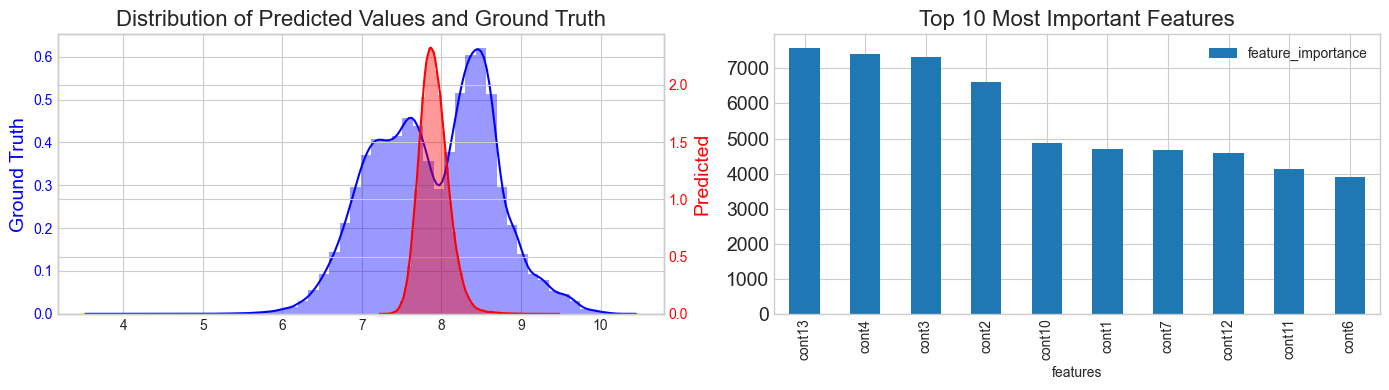

In [15]:
y_pred = run_model(train[features_baseline], 
                   train[target], 
                   test[features_baseline])

- OOF 성능이 0.703 정도 나옴
- 이것을 벤치마크로 사용함  
- 실제와 예측 값의 분포가 다르다.

### 트리기반 모델이 바이모델 분포 핸들링 가능할까?  
가능. 결정트리는 타겟 분포에 민감하지 않다.  
따라서 타겟을 정규분포로 변환할 필요없다.   

실제로 그런지 살펴보자.

아래 예에서는 세개의 피처와 바이모달 분포의 타깃이 있다.   
feature3==0 인경우 타겟은 feature1과 같고, 그렇지 않은 경우 feature2와 같다.

,feature1,feature2,feature3,target
0,3.812905,38.092485,0,3.812905
1,0.265112,54.276124,1,54.276124
2,7.283182,59.026805,0,7.283182
3,-1.025010,46.611860,0,-1.025010
4,13.197715,29.805503,0,13.197715


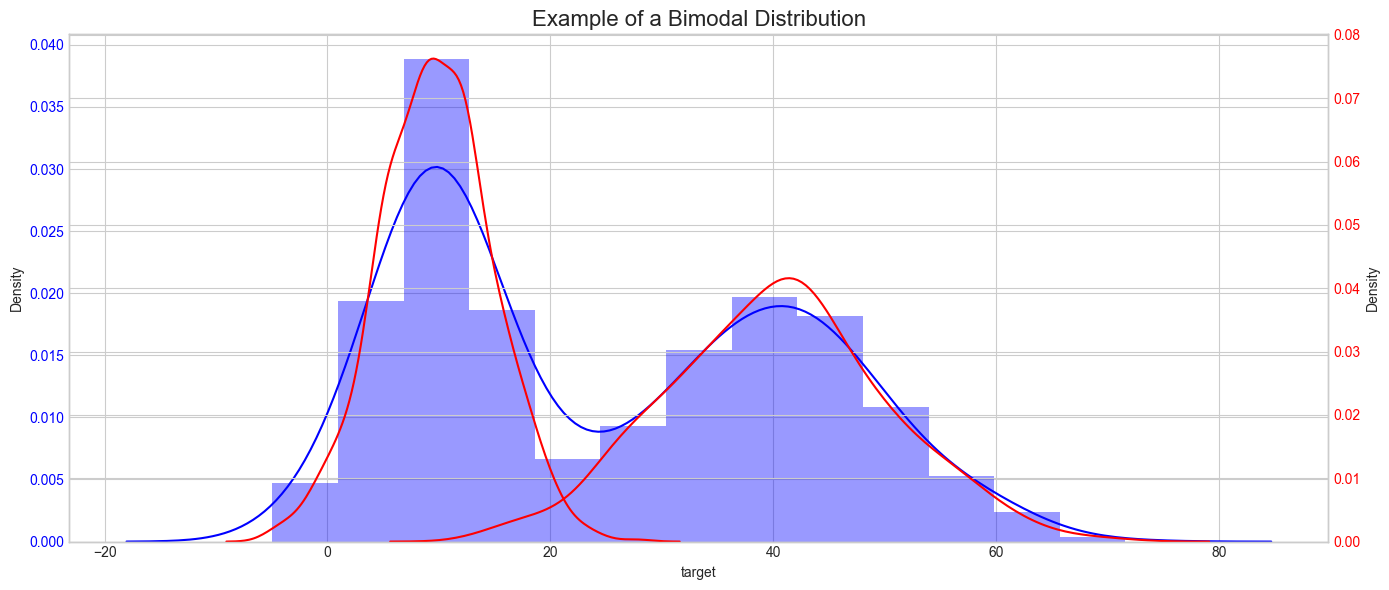

In [16]:
df = pd.DataFrame({'feature1' : np.random.normal(10, 5, 1000),
                   'feature2' : np.random.normal(40, 10, 1000),
                   'feature3' : np.random.randint(0, 2, 1000),
                  })

df['target'] = df.apply(lambda x: x.feature1 if (x.feature3 == 0 ) else x.feature2, axis=1)

display(df.head())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
color = 'blue'
sns.distplot(df.target, ax=ax, color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
sns.distplot(df.feature1, ax=ax2, color=color, hist=False)
sns.distplot((df.feature2), ax=ax2, color=color, hist=False)

ax2.tick_params(axis='y', labelcolor=color)
ax.set_title('Example of a Bimodal Distribution', fontsize=16)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

기준 모델을 그대로 사용하여 데이터 모델링에 사용해 보겠습니다. 아래 결과에서 LightGBM 모델이 바이모달 분포를 처리할 수 있음을 알 수 있습니다.

Fold 1:
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 429
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 24.659998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

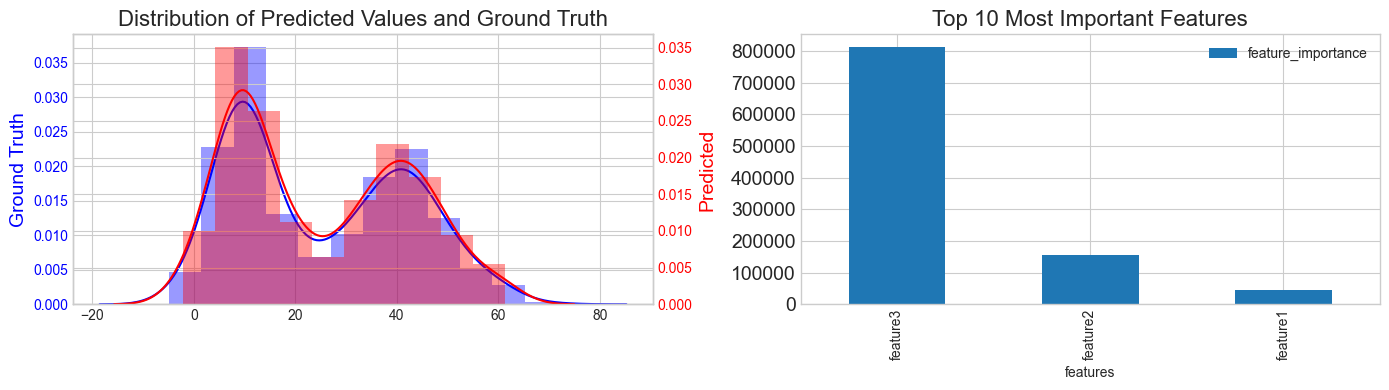

In [17]:
features = df.columns[df.columns.str.startswith('feature')]
target = ['target']

pred = run_model(df[features].head(800), 
          df[target].head(800), 
          df[features].tail(200))

### Feature Engineering Techniques

이론상으로 베이스라인 lgbm모델이 바이모델 분포를 모델링 할 수 있음을 알았다.  
그러나 이것은 피처의 품질에 의존적이다.  
앞에서 우리가 분석하는 데이터는 타겟과 상관도가 낮음을 확인했다.  

여기서는 다양한 fe 기법을 살펴본다.

#### Gaussian Mixture Modelling (GMM)  

두개의 분포를 분리하기위한 비지도 방법이다.

In [18]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42)

gmm.fit(train.target.values.reshape(-1, 1))

train['target_class'] = gmm.predict(train.target.values.reshape(-1, 1))

In [19]:
train

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target,target_class
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043,0
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331,1
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091,0
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716,0
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299994,499995,0.216974,0.735265,0.648648,0.255387,0.616353,0.345197,0.295718,0.304357,0.314351,0.860504,0.315397,0.247682,0.486542,0.288750,7.385215,0
299995,499996,0.545799,0.165139,0.220966,0.190053,0.359362,0.386336,0.365767,0.344217,0.466446,0.454581,0.360251,0.360755,0.292535,0.619984,7.242617,0
299996,499997,0.284401,0.841542,0.957585,0.340383,0.396279,0.330376,0.525687,0.260039,0.378174,0.526925,0.491735,0.516629,0.173521,0.714552,9.592487,1
299997,499998,0.481900,0.622346,0.540032,0.823118,0.283066,0.434283,0.174342,0.710843,0.358690,0.648272,0.984647,1.001110,0.063956,0.377693,8.207951,1


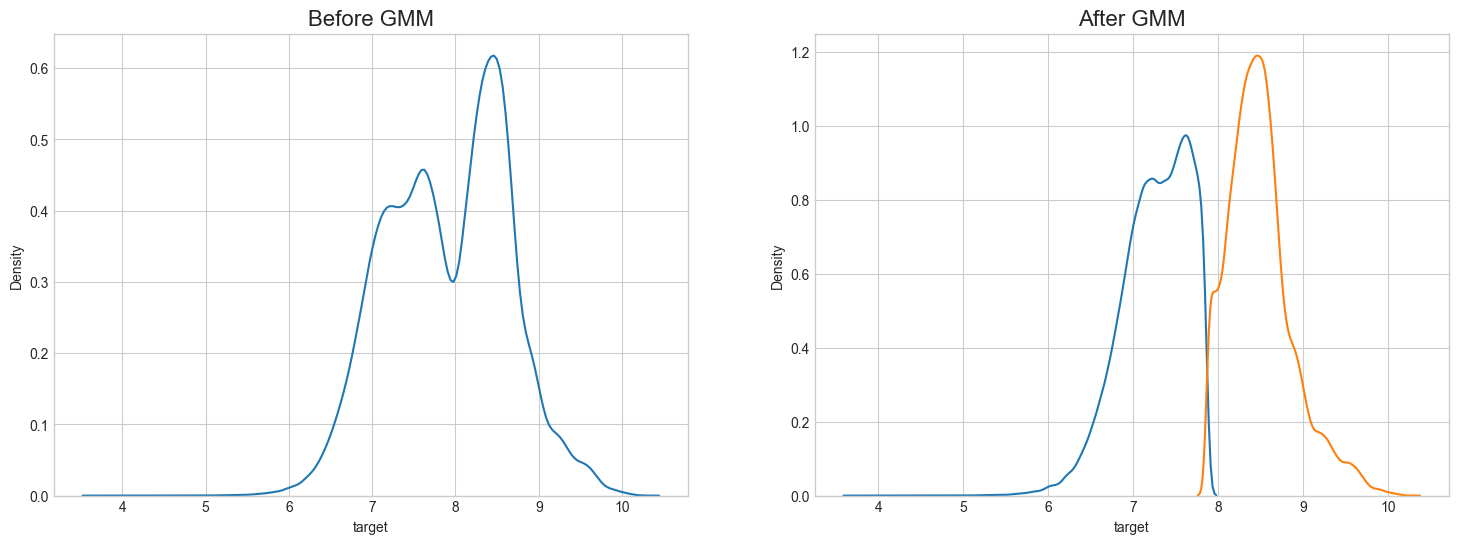

In [20]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.kdeplot(data=train.target, ax=ax[0])
ax[0].set_title('Before GMM', fontsize=16)
sns.kdeplot(data=train[train.target_class==0].target, label='Component 1', ax=ax[1])
sns.kdeplot(data=train[train.target_class==1].target, label='Component 2', ax=ax[1])
ax[1].set_title('After GMM', fontsize=16)
plt.show()

#### 진행 중지